In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pyh5md
import scipy.integrate
from scipy.optimize import leastsq
from glob import glob
import itertools
import tidynamics

plt.rcParams['figure.figsize'] = (8*.7, 3.5)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .2
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 16

π = np.pi

def read_data(group):
    """Read correlation stored using logarithmically spaced blocks as
    stored by RMPCDMD."""
    value = group['value'][:]
    count = group['count'][:]
    value /= count.reshape((-1, 1, 1, 1))
    tau = group['time'][()]
    return value, count, tau

def get_block_data(block, dt):
    """Return an array for the successive times of the block correlator
    and a concatenated array with the correlation value."""
    t_data = []
    data = []
    for i in range(block.shape[0]):
        t = np.arange(block.shape[1])*block.shape[1]**i
        t_data.append(t[1:])
        data.append(block[i,1:,:,:].reshape((-1,3)))

    return np.concatenate(t_data)*dt, np.concatenate(data)

def expfitfunc(p, t):
    """Exponential fitting function"""
    #f0 = p[0]
    f0 = 1
    tau = p[0]
    return f0*np.exp(-t/tau)

def experrfunc(p, t, y):
    return (expfitfunc(p, t)-y)

# whitmer luitjen

def wl_tail(t):
    ν = η/rho
    return 1/(12*rho*(π*ν*t)**1.5)

def wl_rot_tail(t):
    ν = η/rho
    return π / (rho*(4*π*ν*t)**2.5)

### Physical parameters

The values for the mass, moment of inertia and the fluid properties
are directly obtained from the simulation parameters.

In [2]:
# Mass of the colloid assembly
janus_mass = 1505.33
# Moment of inertia
I = 2505.8
# Effective radius of the colloid
R = 3.2
# Gyroscopic ratio
χ = I / (janus_mass*R**2)

# Side of the simulation box
side = 64

sound = np.sqrt(5/3)
# Number density (numerically equal to the mass density)
rho = 10

# Viscosity
η = 4.76
viscosity = η
Dfluid = 1.17


# Partial slip coefficient
Γ = 0.86

# Enskog friction coefficients for translation and rotation

ξENSTRA = 8/3 * np.sqrt(2*π*1) * rho*R**2 * (2-Γ)

ξENSROT = 8/3 * np.sqrt(2*π*1) * rho*R**2 * (1-Γ) / χ

ξHTRA = 6*π*η*R

ξHROT = 8*π*η*R**3

ξTRA = 1/(1/ξENSTRA + 1/ξHTRA)
ξROT = 1/(1/ξENSROT + 1/ξHROT)

print('Translation', 'Enskog', ξENSTRA, 'Stokes', ξHTRA, 'combined', ξTRA)
print('Diffusion', 1/ξTRA)


print('Rotation', 'Enskog', ξENSROT, 'Stokes', ξHROT, 'combined', ξROT)
print('Diffusion', 1/ξROT)

Translation Enskog 780.30335538 Stokes 287.11643579687836 combined 209.887356492
Diffusion 0.00476446040731
Rotation Enskog 589.483871808 Stokes 3920.09640341338 combined 512.427646192
Diffusion 0.00195149502068


In [3]:
1/ξTRA, janus_mass/ξENSTRA, 1/ξROT, 1/ξENSROT

(0.0047644604073120902,
 1.9291599730053983,
 0.0019514950206757954,
 0.0016963992533550575)

### Enskog

From Whitmer Luitjen

$$\xi_e^T = \frac{8}{3} \sqrt{2\pi k_B T m} \gamma a^2 (2-\Gamma)$$

$$\xi_e^R = \frac{8}{3} \sqrt{2\pi k_B T m} \gamma a^2 \frac{1-\Gamma}{\chi}$$

In [4]:
store = {}

In [5]:
# Collect simulation data
EPSB = '01.00'

runs = glob('/path/to/equilibrium/janus/with/{EPSB}*'.format(EPSB=EPSB))

runs.sort()

print(len(runs), "runs found")

24 runs found


In [6]:
store[EPSB] = []
for r in runs:
    data = {}
    with pyh5md.File(r+'/janus.h5', 'r') as a:
        L = a['particles/janus/box/edges'][:]
        obs = a['observables']
        janus = a['particles/janus']
        el = pyh5md.element(obs, 'janus_pos')
        com_pos = el.value[:]
        data['com_pos'] = com_pos
        data['com_pos_dt'] = el.time
        el = pyh5md.element(obs, 'janus_vel')
        com_vel = el.value[:]
        data['com_vel'] = com_vel
        data['com_vel_dt'] = el.time
        el = pyh5md.element(obs, 'omega_body')
        omega_body = el.value[:]
        data['omega_body'] = omega_body
        data['omega_body_dt'] = el.time
        del el
        vacf, vacf_count, vacf_tau = read_data(a['block_correlators/velocity_autocorrelation'])
        block_t, block_vacf = get_block_data(vacf, vacf_tau)
        data['block_vacf'] = block_vacf
        data['block_vacf_time'] = block_t
        wacf, wacf_count, wacf_tau = read_data(a['block_correlators/omega_body_autocorrelation'])
        block_t, block_wacf = get_block_data(wacf, wacf_tau)
        data['block_wacf'] = block_wacf
        data['block_wacf_time'] = block_t
        oacf, oacf_count, oacf_tau = read_data(a['block_correlators/orientation_autocorrelation'])
        block_t, block_oacf = get_block_data(oacf, oacf_tau)
        data['block_oacf'] = block_oacf
        data['block_oacf_time'] = block_t
    store[EPSB].append(data)


<IPython.core.display.Javascript object>


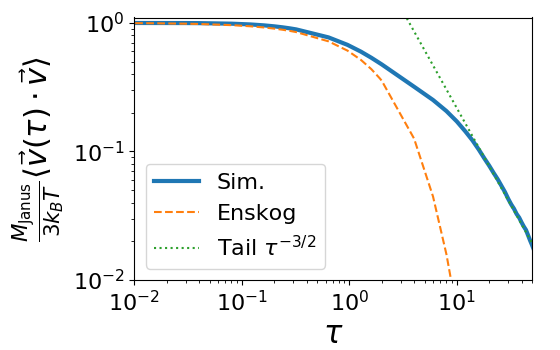

In [7]:
# plot the velocity autocorrelation with Enskog and tail theoretical data

plt.figure()

N_cor = 500
VACF_N_SKIP = 8
vacf_t = np.arange(N_cor)*store[EPSB][0]['com_vel_dt']*VACF_N_SKIP

# Compute the velocity autocorrelation for all realizations
vacf = np.array([tidynamics.acf(data['com_vel'][::VACF_N_SKIP])[:N_cor] for data in store[EPSB]])
vacf = np.mean(vacf, axis=0)

# Normalize the result
vacf *= janus_mass/3

max_short_time = vacf_t[1]

block_vacf = np.array([data['block_vacf'] for data in store[EPSB]])
block_vacf = np.sum(block_vacf, axis=2)
block_vacf = np.mean(block_vacf, axis=0)
block_vacf *= janus_mass/3

block_vacf_t = store[EPSB][0]['block_vacf_time']

# Keep the block vacf for short time and the computed one for later times

consolidated_vacf = np.concatenate([block_vacf[block_vacf_t < max_short_time], vacf[1:]])
consolidated_vacf_t = np.concatenate([block_vacf_t[block_vacf_t < max_short_time], vacf_t[1:]])

plt.plot(consolidated_vacf_t, consolidated_vacf, lw=3, label='Sim.')

plt.plot(consolidated_vacf_t, np.exp(-consolidated_vacf_t*ξENSTRA/janus_mass), label='Enskog', ls='--')

mask = consolidated_vacf_t < 1
solution, ierr = leastsq(experrfunc, [10], args=(consolidated_vacf_t[mask], consolidated_vacf[mask]))

plt.plot(vacf_t[1:], wl_tail(vacf_t[1:])*janus_mass, label=r'Tail $\tau^{-3/2}$', ls=':')

plt.xlim(1e-2, 50)
plt.ylim(1e-2, 1.1)
plt.xscale('log')
plt.loglog()
plt.legend()
plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'$\frac{M_\mathrm{Janus}}{3 k_B T} \langle \vec v(\tau)\cdot \vec v \rangle$', fontsize=22);
plt.savefig('janus_eq_vacf.pdf')

<IPython.core.display.Javascript object>


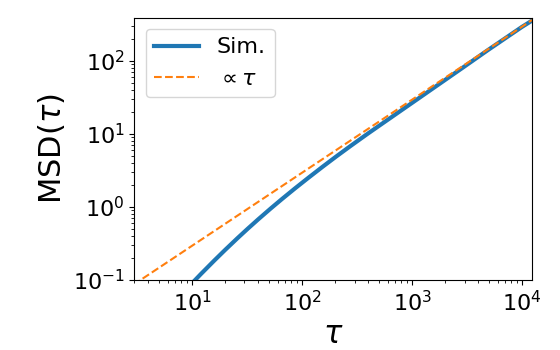

Fitted value for the diffusion coefficient 0.00488694400278


In [8]:
# plot the msd

plt.figure()

count = 0

N_SKIP = 8

N_msd_time = store[EPSB][0]['com_pos'].shape[0]//(N_SKIP*4)

msd_t = np.arange(N_msd_time)*store[EPSB][0]['com_pos_dt']*N_SKIP

rsq_data = np.array([tidynamics.msd(data['com_pos'][::N_SKIP])[:N_msd_time] for data in store[EPSB]])

plt.plot(msd_t, rsq_data.mean(axis=0), label='Sim.', lw=3)

mask = (msd_t>1000) * (msd_t<5000)

fit = np.polyfit(msd_t[mask], rsq_data.mean(axis=0)[mask], 1)

print('Fitted value for the diffusion coefficient', fit[0]/6)

plt.plot(msd_t, msd_t*fit[0], ls='--', label=r'$\propto \tau$')

plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'MSD$(\tau)$', fontsize=22)
plt.loglog()
plt.legend()
plt.xlim(3, 1.5*8192)
plt.ylim(0.1, 390)
plt.savefig('janus_eq_msd.pdf')

<IPython.core.display.Javascript object>


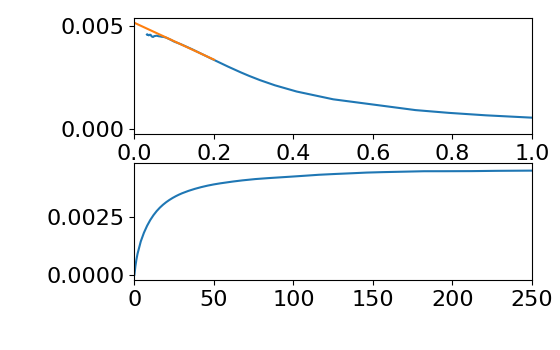

Intercept - extrapolated of the infinite integral 0.00517737220462


(0, 250)

In [9]:
# integrate the vacf

plt.figure()

integ = scipy.integrate.cumtrapz(consolidated_vacf, consolidated_vacf_t, initial=0)[1:]/janus_mass

inv_sqrt_t = 1/np.sqrt(consolidated_vacf_t[1:])

mask = (inv_sqrt_t > 0.1) * (inv_sqrt_t < 0.35)

fit = np.polyfit(inv_sqrt_t[mask], integ[mask], deg=1)

plt.subplot(211)
plt.plot(inv_sqrt_t, integ)

inv_sqrt_t = np.linspace(0, 0.2, 101)

plt.plot(inv_sqrt_t, fit[-1] + fit[0]*inv_sqrt_t)

# use intercept of power-law tail as 1/sqrt(tau) -> 0
print('Intercept - extrapolated of the infinite integral', fit[-1])

plt.xlim(0, 1)

plt.subplot(212)
plt.plot(consolidated_vacf_t[1:], integ)
plt.xlim(0, 250)


<IPython.core.display.Javascript object>


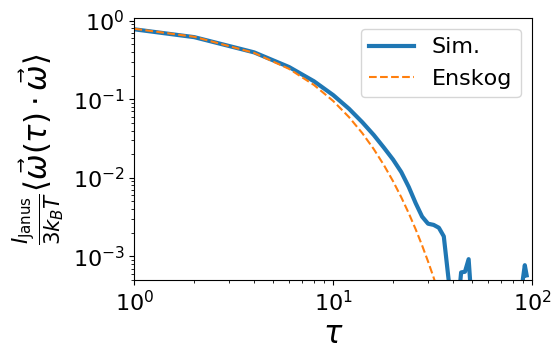

Fitted friction and time 569.956567852 4.39647534801


In [10]:
# plot angular vacf and enskog theoretical data

plt.figure()

N_cor = 700

N_SKIP = 8
t_r = np.arange(N_cor)*store[EPSB][0]['omega_body_dt']*N_SKIP

wacf_data = []
for data in store[EPSB]:
    omega_body = data['omega_body'][::N_SKIP]

    wacf_data.append(tidynamics.acf(omega_body)[:N_cor])

wacf_data = np.array(wacf_data)

m = np.mean(wacf_data, axis=0)
m *= I/3

e = np.std(wacf_data, axis=0)*I/3

max_short_time = t_r[1]

block_wacf = np.array([data['block_wacf'] for data in store[EPSB]])
block_wacf = np.sum(block_wacf, axis=2)
block_e = np.std(block_wacf, axis=0)* I/3
block_wacf = np.mean(block_wacf, axis=0)
block_wacf *= I/3

block_t = store[EPSB][0]['block_wacf_time']

# Keep the block vacf for short time and the computed one for later times

consolidated_wacf = np.concatenate([block_wacf[block_t < max_short_time], m[1:]])
consolidated_wacf_t = np.concatenate([block_t[block_t < max_short_time], t_r[1:]])
consolidated_wacf_e = np.concatenate([block_e[block_t < max_short_time], e[1:]])

plt.plot(consolidated_wacf_t, consolidated_wacf, label='Sim.', lw=3)

mask = consolidated_wacf_t < 45
solution, ierr = leastsq(experrfunc, [10], args=(consolidated_wacf_t[mask], consolidated_wacf[mask]))

plt.plot(consolidated_wacf_t, np.exp(-consolidated_wacf_t*ξENSROT/I), label='Enskog', ls='--')

print("Fitted friction and time", I/solution[0], solution[0])

plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'$\frac{I_\mathrm{Janus}}{3 k_B T} \langle \vec \omega(\tau)\cdot \vec \omega \rangle$', fontsize=22);

plt.legend()
plt.xscale('log')
plt.loglog()
plt.xlim(1, 100)
plt.ylim(5e-4, 1.1)
plt.savefig('janus_eq_wacf.pdf')

<IPython.core.display.Javascript object>


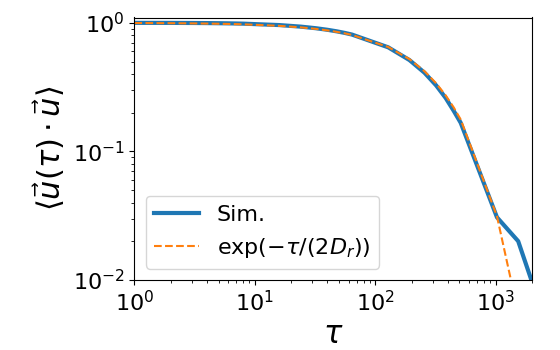

Fitted OACF time 295.548224417
Fitted rotational diffusion 0.00169177128703
Calculated Enskog diffusion 0.00169639925336


In [11]:
# plot the orientation autocorrelation function

plt.figure()

block_oacf = np.array([data['block_oacf'].sum(axis=-1) for data in store[EPSB]])
block_e = np.std(block_oacf, axis=0)
block_oacf = np.mean(block_oacf, axis=0)

block_t = store[EPSB][0]['block_oacf_time']

mask = block_t < 300
solution, ierr = leastsq(experrfunc, [10], args=(block_t[mask], block_oacf[mask]))

plt.plot(block_t, block_oacf, lw=3, label='Sim.')

plt.plot(block_t, expfitfunc(solution, block_t), ls='--', label=r'$\exp(-\tau/(2 D_r))$')

plt.xlim(1, 2000)
plt.ylim(0.01, 1.1)
plt.loglog()

plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'$\langle \vec u(\tau)\cdot \vec u \rangle$', fontsize=22);

plt.legend()

print("Fitted OACF time", solution[0])
print("Fitted rotational diffusion", 1/(2*solution[0]))
print("Calculated Enskog diffusion", 1/ξENSROT)

plt.savefig('janus_eq_oacf.pdf')

In [12]:
# compute the inverse relation betwee Γ and the rotational diffusion coefficient

1 - χ * 2*solution[0] *3/8 / (np.sqrt(2*π*1)*rho*R**2), 1 - χ * ξENSROT *3/8 / (np.sqrt(2*π*1)*rho*R**2), Γ

(0.85961701957541781, 0.85999999999999999, 0.86)